# Data Wrangling

In [149]:
#import the libraries
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import datetime
import time
import json
import re
from timeit import default_timer as timer
import requests
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Gathering

In [150]:
# Gathering Twitter archive dataset
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [151]:
# Requesting the Image Predictions File from a url online
url = " https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

In [152]:
file_name = url.split('/')[-1]

In [153]:
if not os.path.isfile(file_name):
    with open(file_name , 'wb') as file:
        file.write(response.content)

In [154]:
image_prediction_df = pd.read_csv('image-predictions.tsv', sep='\t' )

In [155]:
# Pulling data using Twitter API
consumer_key = 'HZ2gkugOAewbC8NOLZ4b3F4nk'
consumer_secret = 'mCXZ2Kmr4gj8465K6E4mgKZF8n9Xo1mXiuli2KwtaAT81IfNS4'
access_token = '939828970685689857-uLb20W3sBXQmZEIJSX4bp1occHNGTKw'
access_secret = 'CKlDEvP3YXnEZKAdGJvkRSS6GDVB2cVC6WLZDfE22ngzw'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [156]:
#Experimenting to extract one tweet's id information
exp_tweet = api.get_status(archive_df.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

TweepError: [{'code': 89, 'message': 'Invalid or expired token.'}]

In [ ]:
df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df = pd.DataFrame(df_list, columns= ['tweet_id', 'retweet_count', 'favorite_count'])
api_df.head()

# Data Assessment

### Twitter archive Assessment

##### Visual Assessment

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)
archive_df.head()

In [ ]:
archive_df.sample(5)

In [ ]:
image_prediction_df.head()

In [ ]:
api_df.head()

##### programmatic Assessment

In [ ]:
archive_df.info()

In [ ]:
archive_df.name.value_counts()

In [ ]:
#Check for number of pets under each category
(archive_df.loc[:, 'doggo':"puppo"] != 'None') .sum()

In [ ]:
#Check if every pet have only one classification
#Getting all the tweets where the value of both 'doggo' and 'pupper' is not none
nonunique_stage = archive_df[(archive_df['doggo'] != 'None') & (archive_df['pupper'] != 'None')]
nonunique_stage.head()

In [ ]:
#Check if pets have more than one classification
nonunique_stage.iloc[:, -4:].head()

In [ ]:
archive_df['source'].value_counts()

In [ ]:
archive_df.rating_denominator.value_counts()

In [ ]:
archive_df.rating_numerator.value_counts()

In [ ]:
#Investigating tweets about extreme values in numerators.
archive_df[archive_df['rating_numerator'] > 15].text

In [ ]:
#Investigating tweets too low numerators.
archive_df[archive_df['rating_numerator'] < 6].text

In [ ]:
#Investigating tweets have denominators not equal to 10.
archive_df[archive_df['rating_denominator'] != 10].text

### Observations:
#### ( Archive)
1. 'tweet_id' data type in 3 dataframes is (int), it should be to object datatype.
2. There are 181 retweets and 78 replies.
3. Columns for retweets and replies exist so it will be removed.
4. 'timestamp' datatype is string format (object), it should be to datetime datatype.
5. 'timestamp' column contains "+0000", remove it.
6. 'Source' column not clear, remove HTML links.
7. Some cells in 'expanded_urls' column have duplicated urls.
8. Invalid lowercase entries in 'name' column.
9. Some dogs have two stage classifications.
10. There are 4 columns for dog stages (doggo, floofer, pupper, puppo) which will be merged later in one column.
11. Some denominators not equal to 10, will investgate more after removing retweet and replies.
12. Some numerators is too high, will investgate more after removing retweet and replies.
13. Some numerators is too low, will investgate more after removing retweet and replies.
14. Noticed some decimal ratingss in the text while examining.
15. while examining denominators not equal to 10, noticed some entries have no rating at all those will be replaced by missing values.
16. Some images contains more than one dog which affects the ratings number and Multiplies it.

#### Image Predictions Assessment

In [ ]:
image_prediction_df.info()

In [ ]:
# Check prediction table for any duplicated images
len(image_prediction_df[image_prediction_df.jpg_url.duplicated()])

In [ ]:
print(image_prediction_df.p1_dog.value_counts())
print(image_prediction_df.p2_dog.value_counts())
print(image_prediction_df.p3_dog.value_counts())

### Observations:
#### ( Image Predictions)
1. Columns of prediction and confidence  and breed need to be renamed.

#### Twitter API Data Assessment

In [ ]:
api_df

In [ ]:
api_df.info()

### Observations:
#### ( Image Predictions)
1. Need to be merged with archive dataset.

# Quality Issues

#### Twitter archive:
1.  Remove Retweets and Replies as its a key point.
2.  Drop unnecessary columns filled with missing values “in_reply_to_status_id”, “in_reply_to_user_id”, "retweeted_status_id", “retweeted_status_user_id”, “retweeted_status_timestamp”.
3. Convert invalid lowercase entries in "name" column to NaN.
4. String "none" in the 4 dog stage columns should be replaced with empty string("") to merge the 4 columns later.
5. Modify decimal rating_numerators to be valid.
6. Replace entries that it dosn't contain rating at all by missing values.
7. Modifying ratings that is multiplied by the number of dogs in pictuers.
8. Assign all denominator ratings to be equal to 10.
9. Correct rating_numerator less than 6.
10. Remove "+0000" from 'timestamp' column.
11. Convert 'tweet_id' datatype in archive_clean, image_prediction_clean, and api_clean to object and datatype of 'timestamp' to datetime.
12. Extract HTML link from the content of source column to make it more readable.
13. Remove duplicates in 'expanded_urls' column. 

#### Image Predictions:
14. Rename columns of image_predections dataset to be more descriptive.
15. Remove duplicated urls in 'jpg_url' column.

# Tidiness Issues
#### Twitter archive:
1. Merge the 4 dog stage columns into a single column in the archive table.

#### Image Predictions:
2. Reshape Image Predictions from wide to long.

#### Twitter API Data:
3. Merge cleaned Twitter API Data and cleaned archive data table into single data frame.

# Cleaning 

In [ ]:
#copy dataframes
archive_clean = archive_df.copy()
image_prediction_clean = image_prediction_df.copy()
api_clean = api_df.copy()

# Quality Issues: `Twitter archive`

### 1.Define
1. Remove retweets and replies to keep only the original tweets as its the key point.

#### Code

In [ ]:
#Use the image_prediction table to guide the selection and removal of tweets without images in the archive table.
#create list of tweet_ids with images "tweets_with_image".
tweets_with_image = list(image_prediction_clean.tweet_id.unique())

In [ ]:
#chekcing if all tweets with images exist in the archive dataset.
len(tweets_with_image) == archive_clean.tweet_id.isin(tweets_with_image).sum()

In [ ]:
#Removing tweets without images.
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

In [ ]:
#Use the image_prediction table to guide the selection and removal of tweets without images in the API table
# creating list of tweet_ids with images "tweets_with_image"
tweets_with_image = list(image_prediction_clean.tweet_id.unique())

In [ ]:
#chekcing if all tweets with images exist in the API table.
len(tweets_with_image) == api_clean.tweet_id.isin(tweets_with_image).sum()

In [ ]:
#Removing tweets without images.
api_clean = api_clean[api_clean.tweet_id.isin(tweets_with_image)]

In [ ]:
#Use the archive table to guide the selection and removal of tweets without images in the image_prediction.
# creating a list of tweet_ids with images "tweets_with_image".
tweets_with_image = list(archive_clean.tweet_id.unique())

In [ ]:
#chekcing if all tweets with images exist in the image_prediction dataset
len(tweets_with_image) == image_prediction_clean.tweet_id.isin(tweets_with_image).sum()

In [ ]:
#Removing tweets without images.
image_prediction_clean = image_prediction_clean[image_prediction_clean.tweet_id.isin(tweets_with_image)]

In [ ]:
#Extract tweets that include data in the "retweet_status_id" column.
retweet_entries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_entries].shape[0]

In [ ]:
# Dropping the retweets from the archive data set
archive_clean = archive_clean[~retweet_entries]

In [ ]:
#Extract tweets that include data in the "in_reply_to_status_id" column.
retweet_entries = archive_clean.in_reply_to_status_id.notnull()
archive_clean[retweet_entries].shape[0]

In [ ]:
# Dropping the replies from the archive data set
archive_clean = archive_clean[~retweet_entries]

In [ ]:
#check if image_prediction table have tweet ids not in the archive table
np.logical_not(image_prediction_clean.tweet_id.isin(list(archive_clean.tweet_id)))

In [ ]:
# Dropping the retweets and replies from the image prediction dataframe
image_prediction_clean[~np.logical_not(image_prediction_clean.tweet_id.isin(list(archive_clean.tweet_id)))]

In [ ]:
#Check if image_prediction table have tweet ids not in the API table
np.logical_not(image_prediction_clean.tweet_id.isin(list(api_clean.tweet_id)))

In [ ]:
#Dropping the retweets and replies from the API dataframe
api_clean[~np.logical_not(api_clean.tweet_id.isin(list(archive_clean.tweet_id)))]

#### Test

In [ ]:
archive_clean.info()

In [ ]:
image_prediction_clean.info()

In [ ]:
api_clean.info()

### 2.Define
2. Drop unnecessary columns filled with missing values “in_reply_to_status_id”, “in_reply_to_user_id”, "retweeted_status_id", “retweeted_status_user_id”, “retweeted_status_timestamp”.

#### Code

In [ ]:
archive_clean = archive_clean.drop(columns=['in_reply_to_status_id', 
                                                'in_reply_to_user_id', 
                                                'retweeted_status_id', 
                                                'retweeted_status_user_id', 
                                                'retweeted_status_timestamp'])

#### Test

In [ ]:
archive_clean.columns

### 3.Define
3. Convert invalid lowercase entries in "name" column to NaN.

#### Code

In [ ]:
#Check for lowercase entries in "name" column.
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_df.iterrows():  
    if len(row['name']) < 3 and row['name'][0].islower():
        print(row['name'])

In [ ]:
#Check for lowercase entries in "name" column.
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_df.iterrows():  
    if len(row['name']) > 3 and row['name'][0].islower():
        print(row['name'])

In [ ]:
#Replacing invalid lowercase entries with NaN.
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('an', c_name)
        elif row['name'] == 'my':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('my', c_name)
        elif row['name'] == 'by':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('by', c_name)
        elif row['name'] == "such":
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'quite'] = archive_clean.loc[index,'name'].replace('such', c_name)
        elif row['name'] == 'quite':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('quite', c_name)
        elif row['name'] == 'incredibly':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('incredibly', c_name)
        elif row['name'] == 'very':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('very', c_name)
        elif row['name'] == 'just':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('just', c_name)
        elif row['name'] == 'actually':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('actually', c_name)
        elif row['name'] == 'getting':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('getting', c_name)
        elif row['name'] == 'this':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('this', c_name)
        elif row['name'] == 'unacceptable':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('unacceptable', c_name)
        elif row['name'] == 'infuriating':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('infuriating', c_name)
        elif row['name'] == 'officially':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('officially', c_name)
        elif row['name'] == 'life':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('life', c_name)
        elif row['name'] == 'light':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('light', c_name)
        elif row['name'] == 'space':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('space', c_name)
    except IndexError:
        archive_clean.loc[index,'name'] = np.nan

#### Test

In [ ]:
archive_clean.name.value_counts(dropna = False)

### 4.Define
4. Replacing the string "None" in the 4 dog stage columns with empty string "" so merging the 4 columns will be smooth while fixing its tidiness.

##### Code

In [ ]:
archive_clean.iloc[:, -4:  ] = archive_clean.iloc[:, -4:  ].replace("None","")

#### Test

In [ ]:
archive_clean.iloc[:, -4:  ].value_counts()

# 5.Define
5. Modifying decimal 'rating_numerators' to be valid.

##### Code

In [ ]:
archive_clean[archive_clean['rating_numerator'] > 15].rating_numerator.value_counts()

In [ ]:
archive_clean[archive_clean['rating_numerator'] > 15].text

In [ ]:
#Checking rows that have decimal numerators.
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id', 'text', 'rating_numerator']]

In [ ]:
#Change Datatype of rating_numerator from int to float.
archive_clean['rating_numerator']= archive_clean['rating_numerator'].astype(float)

In [ ]:
#Extracting decimal numerator and assign it to "rating_numerator" column.
archive_clean['rating_numerator'] = archive_clean.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')

#### Test

In [ ]:
#Checking "rating_numerator" column after assigning the correct numerator.
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id','text', 'rating_numerator']]

# 6.Define
6. Replace entries that it dosn't contain rating at all by missing values.

##### Code

In [ ]:
#Checking for other extreme values in numerators.
archive_clean[archive_clean['rating_numerator'] > 15].rating_numerator.value_counts()

In [ ]:
archive_clean[archive_clean['rating_numerator'] > 15].text

In [ ]:
#After checking every tweet, found 3 tweets got no ratings at all so they will be replaced with missing values np.nan.
archive_clean.loc[archive_clean['rating_numerator'] == 24]

In [ ]:
archive_clean.loc[archive_clean['rating_numerator'] == 420]

In [ ]:
archive_clean.loc[archive_clean['rating_numerator'] == 1776]

In [ ]:
#Replacing invalid ratings of the 3 tweets with missing values using np.nan.
archive_clean.loc[archive_clean.rating_numerator.isin([1776, 24, 420]), ['rating_numerator', 'rating_denominator']] = np.nan

#### Test

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 810984652412424192 ]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 670842764863651840 ]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 749981277374128128 ]

# 7.Define
7. Modifying ratings that is multiplied by the number of dogs in pictuers.

##### Code

In [ ]:
archive_clean[archive_clean['rating_numerator'] > 15].text

In [ ]:
# Calculating the dogs counts in the tweets featuring many dogs
dogs_count = archive_clean.rating_denominator[ archive_clean.rating_numerator >= 40 ]/10

In [ ]:
# Check the dog_count with their indices:
print(dogs_count)

In [ ]:
# Performing the Calculations
archive_clean.loc[archive_clean.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [archive_clean.rating_numerator[archive_clean.rating_numerator >= 40]/dogs_count , 10]

#### Test

In [ ]:
archive_clean[archive_clean['rating_numerator'] > 15].rating_numerator.value_counts()

# 8.Define
8. Assign all denominator ratings to be equal to 10.

##### Code

In [ ]:
archive_clean[archive_clean['rating_denominator'] != 10].rating_denominator

In [ ]:
archive_clean[archive_clean['rating_denominator'] != 10].text

In [ ]:
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].replace([11], 10)

In [ ]:
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].replace([20], 10)

In [ ]:
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].replace([2], 10)

##### Test

In [ ]:
archive_clean[archive_clean['rating_denominator'] != 10].rating_denominator

In [ ]:
archive_clean.rating_denominator.value_counts()

In [ ]:
archive_clean[archive_clean['rating_denominator'] != 10].text

# 9.Define
9. Correcting rating_numerator less than 6 that their actual ratings inside the text.

##### Code

In [ ]:
archive_clean[archive_clean['rating_numerator'] < 6].rating_numerator.value_counts()

In [ ]:
archive_clean.loc[archive_clean['rating_numerator'] < 6]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 722974582966214656]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 674646392044941312]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 666287406224695296]

In [ ]:
archive_clean.loc[(archive_clean.tweet_id == 722974582966214656),'rating_numerator'] = 13

In [ ]:
archive_clean.loc[(archive_clean.tweet_id == 674646392044941312),'rating_numerator'] = 8

In [ ]:
archive_clean.loc[(archive_clean.tweet_id == 666287406224695296),'rating_numerator'] = 9

#### Test

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 722974582966214656]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 674646392044941312]

In [ ]:
archive_clean.loc[archive_clean['tweet_id'] == 666287406224695296]

### 10.Define:
10. Remove "+0000" from 'timestamp' column.

#### Code

In [ ]:
archive_clean.timestamp = archive_clean.timestamp.str.strip('+0000')

#### Test

In [ ]:
archive_clean.head()

### 11.Define:
11. Convert tweet_id data type in archive_clean, image_prediction_clean, and api_clean.
  - Convert data type of 'timestamp' to datetime

#### Code

In [ ]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

In [ ]:
image_prediction_clean.tweet_id = image_prediction_clean.tweet_id.astype(str)

In [ ]:
api_clean.tweet_id = api_clean.tweet_id.astype(str)

In [ ]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#### Test

In [ ]:
archive_clean.tweet_id.head()

In [ ]:
image_prediction_clean.tweet_id.head()

In [ ]:
api_clean.tweet_id.head()

In [ ]:
archive_clean.timestamp.head()

### 12.Define:
12. Extract HTML link from the content of 'source' column to make it more readable.

#### Code

In [ ]:
archive_clean.source=archive_clean.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

#### Test

In [ ]:
archive_clean.source.value_counts()

In [ ]:
archive_clean.head()

### 13.Define:
13. Remove duplicates in 'expanded_urls' column.

#### Code

In [ ]:
archive_clean.expanded_urls = archive_clean.expanded_urls.str.split(",", expand=True)[0]

#### Test

In [ ]:
archive_clean.head()

# Quality Issues: `Image Predictions`

#### 14.Define:
14. Rename columns of image_predections dataset to be more descriptive

##### Code

In [ ]:
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_prediction_clean.columns = cols

##### Test

In [ ]:
image_prediction_clean.head()

#### 15.Define:
15. Remove duplicated urls in 'jpg_url' column.

##### Code

In [ ]:
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')

##### Test

In [ ]:
sum(image_prediction_clean['jpg_url'].duplicated())

# Tidiness Issues `Twitter archive`

### 1.Define:
1. Combine the 4 dog stage columns into a single column in the archive table.

##### Code

In [ ]:
archive_clean['dog_stage'] = archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']

In [ ]:
#Droping 4 dog stage columns after merging them in one column.
archive_clean = archive_clean.drop(columns=['doggo', 'floofer', 'pupper','puppo'])

In [ ]:
##checking which rows contains multiple stages and add separator between the stages.
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'

In [ ]:
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'

In [ ]:
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'

In [ ]:
#Replace the empty strings with np.nan
archive_clean.dog_stage =archive_clean.dog_stage.replace('' ,np.nan)

#### Test

In [ ]:
#checking the new dog_stage column
archive_clean.head()

In [ ]:
#check for the separation of classifications
archive_clean.dog_stage.value_counts()

# Tidiness Issues `Image Predictions`

### 2.Define:
2. Reshape Image Predictions from wide to long.

##### Code

In [ ]:
# Reshape the dataframe
image_prediction_clean = pd.wide_to_long(image_prediction_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

#### Test

In [ ]:
image_prediction_clean

# Tidiness Issues `Image Predictions`

### 3.Define:
3. Merge cleaned Twitter API Data and cleaned archive data table into single data frame.
Merge all 3 datasets into 1 final dataset instead of 2 datasets.

##### Code

In [ ]:
#Merge cleaned archive with cleaned API data to able to analyse.
combined_df = pd.merge(archive_clean, api_clean, on='tweet_id' )

In [ ]:
#Merge combined df with cleaned image predictions data to able to analyse.
master_df = pd.merge(combined_df, image_prediction_clean, on='tweet_id' )

##### Test

In [ ]:
combined_df.head(1)

In [ ]:
master_df.head(1)

# Storing, Analyzing, and Visualizing Data 

In [ ]:
# Merge all 3 datasets into 1 final dataset and store them in CSV file with name 'twitter_archive_master.csv'
master_df.to_csv('twitter_archive_master.csv', index=False)

In [ ]:
master_df.columns

In [ ]:
master_df.head(1)

###  Analyzing master data frame.

In [ ]:
combined_df.head()

In [ ]:
combined_df.shape

In [ ]:
combined_df.info()

In [ ]:
combined_df.describe()

In [ ]:
master_df.describe()

# Visualizing Data :

### Insight 1: (With Visualization)
 - Most Common Dog breed in all tweets.

In [157]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,7428,35177,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,orange,0.097049,False
1,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,7428,35177,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,bagel,0.085851,False
2,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,7428,35177,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,3,banana,0.076110,False
3,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,5521,30446,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,1,Chihuahua,0.323581,True
4,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,5521,30446,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,0.090647,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,666029285002620928,2015-11-15 23:05:30,Twitter for iPhone,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10.0,NaN,NaN,41,118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True
5693,666029285002620928,2015-11-15 23:05:30,Twitter for iPhone,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10.0,NaN,NaN,41,118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,3,Rhodesian_ridgeback,0.072010,True
5694,666020888022790149,2015-11-15 22:32:08,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN,445,2338,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
5695,666020888022790149,2015-11-15 22:32:08,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN,445,2338,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True


IndexError: index 0 is out of bounds for axis 0 with size 0

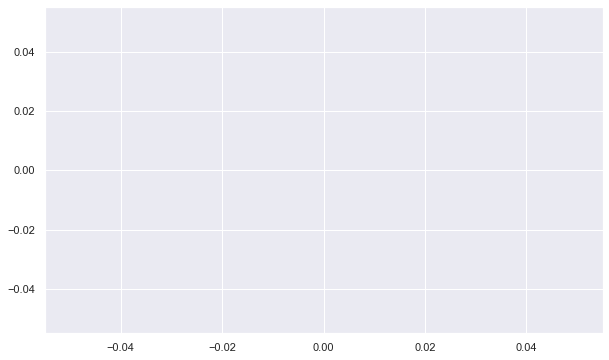

In [165]:
master_df[master_df.prediction == True].groupby(['prediction']).favorite_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');
plt.xlabel('Avg_favorites_count')
plt.ylabel('Dog Breed');

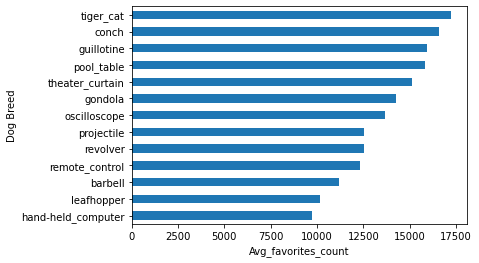

In [158]:
master_df.groupby(['prediction']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');
plt.xlabel('Avg_favorites_count')
plt.ylabel('Dog Breed');

In [159]:
MCDB = master_df['prediction'].value_counts()
MCDB

Labrador_retriever                247
golden_retriever                  241
Chihuahua                         172
Pembroke                          134
Cardigan                          109
toy_poodle                        99 
Pomeranian                        97 
pug                               88 
chow                              87 
French_bulldog                    87 
Chesapeake_Bay_retriever          82 
cocker_spaniel                    80 
Eskimo_dog                        79 
Siberian_husky                    72 
beagle                            70 
kuvasz                            66 
malamute                          63 
Staffordshire_bullterrier         62 
Pekinese                          62 
Samoyed                           59 
kelpie                            56 
miniature_pinscher                54 
American_Staffordshire_terrier    53 
Great_Pyrenees                    51 
miniature_poodle                  51 
collie                            48 
Italian_grey

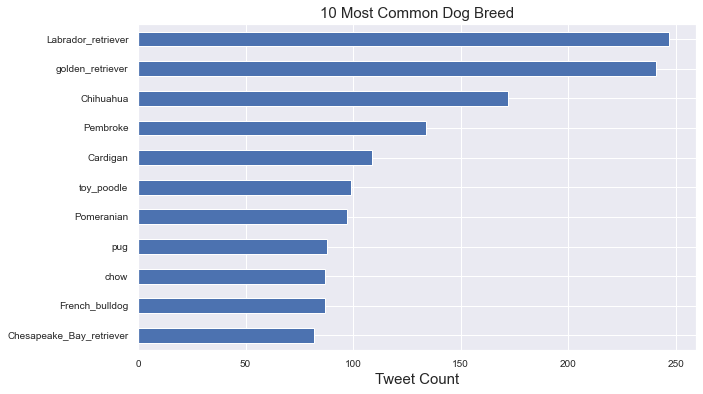

In [160]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
top_10_dogs = master_df['prediction'].value_counts()[10::-1].plot(kind='barh',fontsize=10);
plt.title("10 Most Common Dog Breed", size=15)
plt.xlabel("Tweet Count", size=15);
plt.savefig("10 Most Common Dog Breed.png")

### Insight 2: (With Visualization)
 - Most Common Dog Stage in all tweets.

In [161]:
MCDS = combined_df['dog_stage'].value_counts()
MCDS

pupper           201
doggo            62 
puppo            22 
doggo-pupper     8  
floofer          7  
doggo-floofer    1  
doggo-puppo      1  
Name: dog_stage, dtype: int64

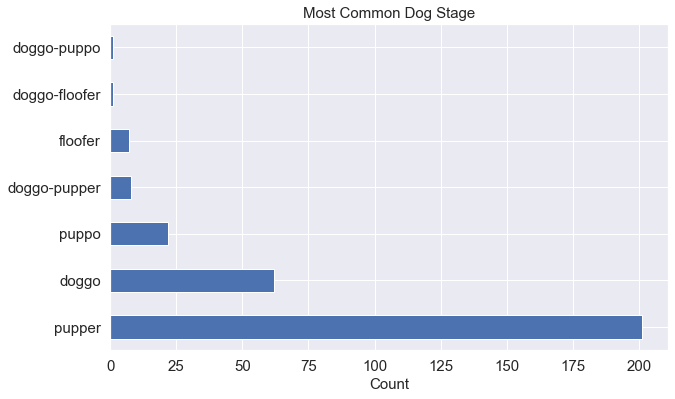

In [162]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
top_10_dogs = combined_df['dog_stage'].value_counts().plot(kind='barh',fontsize=15);
plt.title("Most Common Dog Stage", size=15)
plt.xlabel("Count", size=15);
plt.savefig("Most Common Dog Stage")

### Insight 3: (With Visualization)
 - Average Interactions With Different Dog Stages.

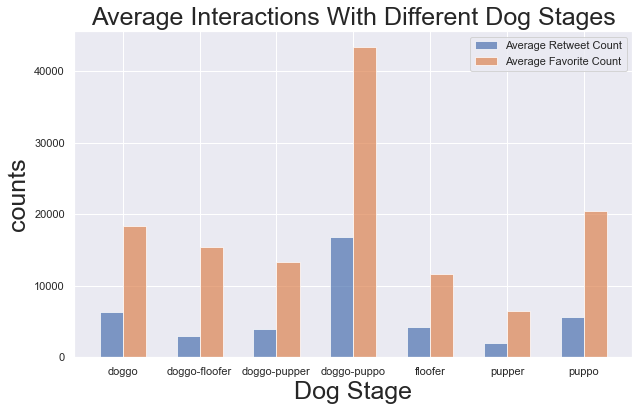

In [163]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
avg_retweet_count_dog_stage = combined_df.groupby('dog_stage').retweet_count.mean()
avg_retweet_count_dog_stage.index
avg_favorite_count_dog_stage = combined_df.groupby('dog_stage').favorite_count.mean()

width = 0.3
ind = np.arange(len(avg_favorite_count_dog_stage))
locations = ind + width / 2
labels = ('doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo')
plt.bar(ind, avg_retweet_count_dog_stage, width, alpha=.7, label='Average Retweet Count')
plt.bar(ind + width, avg_favorite_count_dog_stage, width, alpha=.7, label='Average Favorite Count')
    
plt.ylabel('counts', size=25)
plt.xlabel('Dog Stage', size=25)
plt.title('Average Interactions With Different Dog Stages', size=25)
locations = ind + width / 2
labels = ('doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo')
plt.xticks(locations, labels)

plt.legend();
plt.savefig("Average Interactions")

### Insight 4: (With Visualization)
 - Over all Interactions With Different Dog Stages

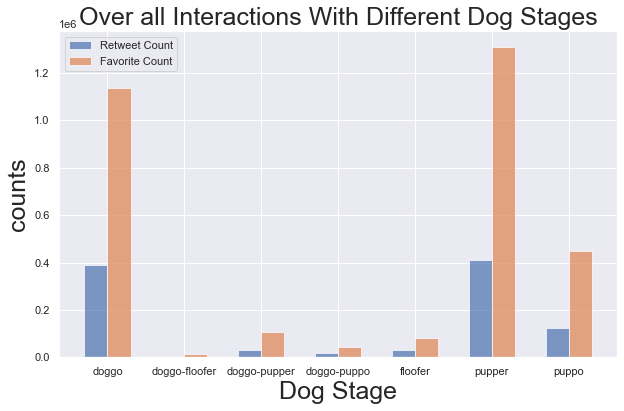

In [164]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
retweet_count_dog_stage = combined_df.groupby('dog_stage').retweet_count.sum()
retweet_count_dog_stage.index
favorite_count_dog_stage = combined_df.groupby('dog_stage').favorite_count.sum()

width = 0.3
ind = np.arange(len(avg_favorite_count_dog_stage))
locations = ind + width / 2
labels = ('doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo')
plt.bar(ind, retweet_count_dog_stage, width, alpha=.7, label='Retweet Count')
plt.bar(ind + width, favorite_count_dog_stage, width, alpha=.7, label='Favorite Count')
    
plt.ylabel('counts', size=25)
plt.xlabel('Dog Stage', size=25)
plt.title('Over all Interactions With Different Dog Stages', size=25)
locations = ind + width / 2
labels = ('doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo')
plt.xticks(locations, labels)

plt.legend();
plt.savefig("Over all Interactions")